In [1]:
import tensorflow as tf
from tensorflow.keras.applications import Xception, ResNet101
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import os


In [2]:
# Set seed for reproducibility
def set_seed(seed=42):
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)


In [3]:
set_seed(42)

In [4]:
# Specify the classes to include
selected_classes = {"Diabetic Retinopathy", "Glaucoma", "Healthy", "Macular Scar", "Myopia"}

In [5]:
# Define paths for train, validation, and test datasets
train_dataset_path = "/kaggle/input/aug-v100/output"
val_dataset_path = "/kaggle/input/aug-v100/val"
test_dataset_path = "/kaggle/input/aug-v100/test"

In [6]:
# Helper function to filter available classes
def filter_classes(data_dir, selected_classes):
    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"Directory not found: {data_dir}")
    available_classes = set(os.listdir(data_dir))
    filtered_classes = available_classes.intersection(selected_classes)
    return [cls for cls in filtered_classes if os.path.isdir(os.path.join(data_dir, cls))]


In [7]:
# Filter classes for train, validation, and test datasets
filtered_train_classes = filter_classes(train_dataset_path, selected_classes)
filtered_val_classes = filter_classes(val_dataset_path, selected_classes)
filtered_test_classes = filter_classes(test_dataset_path, selected_classes)


In [8]:
# Check if any classes are available
if not filtered_train_classes or not filtered_val_classes or not filtered_test_classes:
    raise ValueError("No matching classes found in the dataset directories!")

# Set the number of classes
num_classes = len(filtered_train_classes)


In [9]:
# Load datasets using image_dataset_from_directory
def load_dataset(path, classes):
    return tf.keras.utils.image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='int',
        class_names=classes,
        batch_size=64,
        image_size=(224, 224)
    )

In [10]:
train_dataset = load_dataset(train_dataset_path, filtered_train_classes)
val_dataset = load_dataset(val_dataset_path, filtered_val_classes)
test_dataset = load_dataset(test_dataset_path, filtered_test_classes)


Found 5131 files belonging to 5 classes.
Found 484 files belonging to 5 classes.
Found 482 files belonging to 5 classes.


In [11]:
# Normalize the datasets
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))


In [12]:
# Prepare datasets for two inputs
def prepare_inputs(image, label):
    return {"xception_input": image, "resnet_input": image}, label


In [13]:
train_dataset = train_dataset.map(prepare_inputs).shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(prepare_inputs).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(prepare_inputs).prefetch(tf.data.AUTOTUNE)

In [14]:
# Define Xception and ResNet101 branches
xception_input = Input(shape=(224, 224, 3), name="xception_input")
resnet_input = Input(shape=(224, 224, 3), name="resnet_input")

xception_base = Xception(weights="imagenet", include_top=False, input_tensor=xception_input)
xception_output = GlobalAveragePooling2D()(xception_base.output)

resnet_base = ResNet101(weights="imagenet", include_top=False, input_tensor=resnet_input)
resnet_output = GlobalAveragePooling2D()(resnet_base.output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [15]:
# Concatenate outputs
combined_output = concatenate([xception_output, resnet_output])

# Add fully connected layer and output
final_output = Dense(num_classes, activation="softmax")(combined_output)

# Define model
model = Model(inputs=[xception_input, resnet_input], outputs=final_output)

In [16]:
# Set pretrained layers to non-trainable
#for layer in xception_base.layers:
    #layer.trainable = False
#for layer in resnet_base.layers:
    #layer.trainable = False

In [17]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [18]:
# Train the model
num_epochs = 50
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=num_epochs,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("best_ensemble_model.keras", save_best_only=True, monitor="val_accuracy"),
        tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=20, restore_best_weights=True)
    ]
)


Epoch 1/50


I0000 00:00:1737267196.063991      75 service.cc:145] XLA service 0x7d8320002680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737267196.064052      75 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1737267196.064064      75 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1737267307.379831      75 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_132', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1737267307.495765      75 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


81/81 ━━━━━━━━━━━━━━━━━━━━ 458s 3s/step - accuracy: 0.5512 - loss: 1.2351 - val_accuracy: 0.1033 - val_loss: 8534008.0000
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.7424 - loss: 0.6879 - val_accuracy: 0.2789 - val_loss: 877.5186
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.8048 - loss: 0.5263 - val_accuracy: 0.2789 - val_loss: 12.5648
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.8294 - loss: 0.4681 - val_accuracy: 0.2273 - val_loss: 2.0324
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.8376 - loss: 0.4381 - val_accuracy: 0.2789 - val_loss: 37.6378
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.8735 - loss: 0.3323 - val_accuracy: 0.2128 - val_loss: 3.3739
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.8794 - loss: 0.3236 - val_accuracy: 0.2789 - val_loss: 2.7610
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.9039 - loss: 0.2613 - val_accuracy: 0.2583 - va

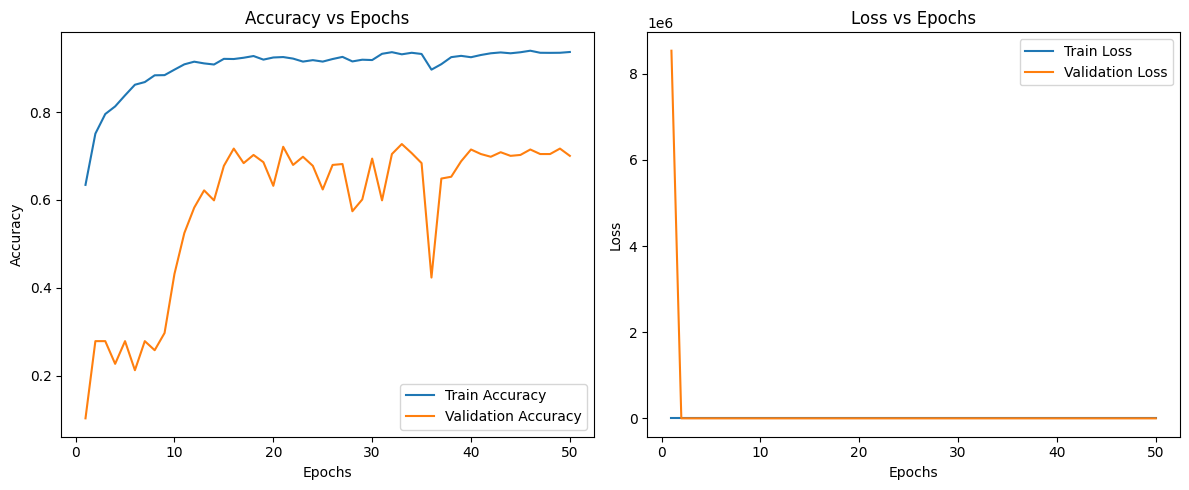

In [19]:
# Plot training and validation metrics
def plot_training_history(history):
    epochs = range(1, len(history.history["accuracy"]) + 1)
    
    # Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history["accuracy"], label="Train Accuracy")
    plt.plot(epochs, history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history["loss"], label="Train Loss")
    plt.plot(epochs, history.history["val_loss"], label="Validation Loss")
    plt.title("Loss vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [20]:
import numpy as np
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:

# Load the best model
best_model = tf.keras.models.load_model("best_ensemble_model.keras")

In [22]:

# Evaluate on the test dataset
test_loss, test_accuracy = best_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.7418 - loss: 1.4268
Test Loss: 1.3867, Test Accuracy: 74.07%


In [23]:
# Generate predictions and true labels
y_true = []
y_pred = []


In [24]:
for data, labels in test_dataset:
    y_true.extend(labels.numpy())  # Append true labels
    preds = np.argmax(best_model.predict(data), axis=-1)  # Predict and take the class with max probability
    y_pred.extend(preds)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
class_report = classification_report(
    y_true,
    y_pred,
    target_names=selected_classes,
    digits=4
)
print("\nClassification Report:")
print(class_report)


2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step

Classification Report:
                      precision    recall  f1-score   support

Diabetic Retinopathy     0.7778    0.6364    0.7000        44
        Macular Scar     0.6818    0.5882    0.6316       102
              Myopia     0.5965    0.7556    0.6667       135
            Glaucoma     0.9404    0.9404    0.9404       151
             Healthy     0.6944    0.5000    0.5814        50

            accuracy                         0.7407       482
           macro avg     0.7382    0.6841    0.7040       482
        weighted avg     0.7490    0.7407    0.7392       482



Cohen's Kappa: 0.6539

Sensitivity per class:
Diabetic Retinopathy: 0.6364
Macular Scar: 0.5882
Myopia: 0.7556
Glaucoma: 0.9404
Healthy: 0.5000

F1 Scores per class (for reference):
Diabetic Retinopathy: 0.6364
Macular Scar: 0.5882
Myopia: 0.7556
Glaucoma: 0.9404
Healthy: 0.5000


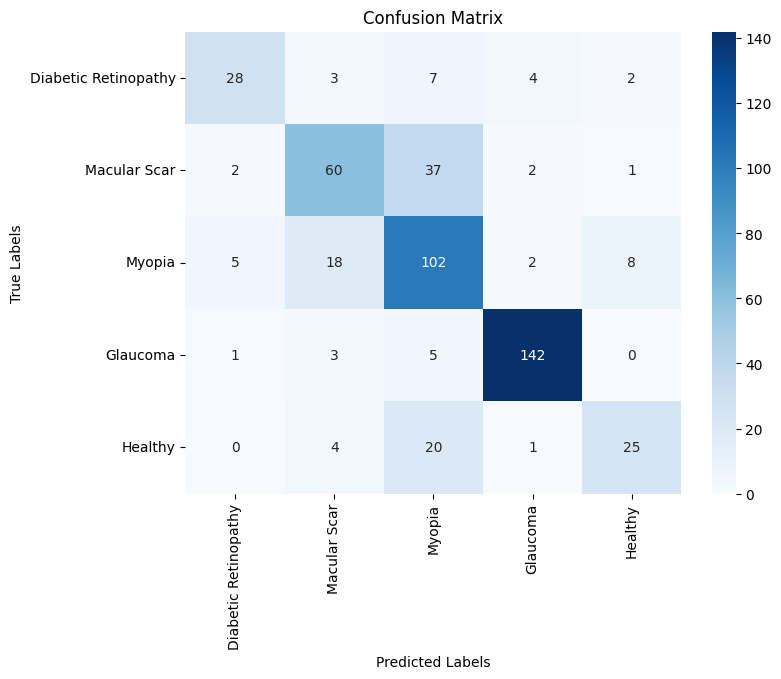

In [25]:
# Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Sensitivity (Recall per class)
sensitivity_per_class = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print("\nSensitivity per class:")
for i, class_name in enumerate(selected_classes):
    print(f"{class_name}: {sensitivity_per_class[i]:.4f}")

# F1 score
f1_scores = 2 * (sensitivity_per_class * sensitivity_per_class) / (sensitivity_per_class + sensitivity_per_class)
print("\nF1 Scores per class (for reference):")
for i, class_name in enumerate(selected_classes):
    print(f"{class_name}: {f1_scores[i]:.4f}")

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=selected_classes, yticklabels=selected_classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()